# OSMnx

https://osmnx.readthedocs.io/en/stable/

OSMnx is a Python package that lets you download geospatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks and any other geospatial geometries.


In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [2]:
ox.settings.use_cache = True
ox.settings.log_console=True

### Retrieve Street Network from OSM Data

* drive - get drivable public streets (but not service roads)
* drive_service - get drivable streets, including service roads
* walk - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
* bike - get all streets and paths that cyclists can use
* all - download all non-private OSM streets and paths
* all_private - download all OSM streets and paths, including private-access ones


Functions:


* graph.graph_from_bbox
* graph.graph_from_address
* graph.graph_from_place
* graph.graph_from_point



In [3]:
place = "Basel, Switzerland"
graph = ox.graph.graph_from_place(place, network_type='drive')

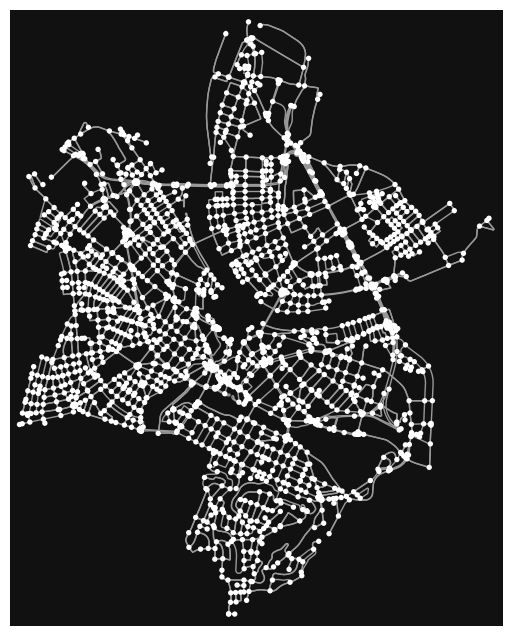

In [4]:
fig, ax = ox.plot.plot_graph(graph)

#### Save Graph as GeoPackage

There are two layers:

* edges
* nodes


In [5]:
ox.io.save_graph_geopackage(graph, filepath='geodata/network-shape.gpkg')

In [6]:
nodes, streets = ox.graph_to_gdfs(graph)

In [7]:
len(streets)

4651

In [8]:
streets.head()

osmid bridge  \
u      v          key                                                    
453270 453273     0                                   128689911    yes   
453273 2914357911 0           [748680217, 748680218, 287871181]    yes   
456106 3404666393 0    [102266441, 102266442, 4310932, 4310933]    yes   
       456113     0                        [22948918, 88967758]    yes   
456113 1402180932 0           [413310946, 748794012, 185411911]    yes   

                       oneway   lanes    ref        highway  maxspeed  \
u      v          key                                                   
453270 453273     0      True       3  A2;A3       motorway        80   
453273 2914357911 0      True  [3, 4]  A2;A3       motorway        80   
456106 3404666393 0      True       2    NaN  motorway_link        80   
       456113     0      True       2  A2;A3       motorway        80   
456113 1402180932 0      True  [3, 4]  A2;A3       motorway  [60, 80]   

                      reversed   length  \
u      v          key                     
453270 453273     0      False  373.289   
453273 2914357911 0      False  423.063   
456106 3404666393 0      False  504.353   
       456113     0      False  551.274   
456113 1402180932 0      False  463.892   

                                                                geometry  \
u      v          key                                                      
453270 453273     0    LINESTRING (7.61560 47.55514, 7.61595 47.55441...   
453273 2914357911 0    LINESTRING (7.61602 47.55185, 7.61596 47.55162...   
456106 3404666393 0    LINESTRING (7.61730 47.54435, 7.61665 47.54455...   
       456113     0    LINESTRING (7.61730 47.54435, 7.61671 47.54463...   
456113 1402180932 0    LINESTRING (7.61537 47.54865, 7.61564 47.54935...   

                                          name junction tunnel width access  
u      v          key                                                        
453270 453273     0                        NaN      NaN    NaN   NaN    NaN  
453273 2914357911 0                        NaN      NaN    NaN   NaN    NaN  
456106 3404666393 0    Galerie Gellerthochhaus      NaN    NaN   NaN    NaN  
       456113     0                        NaN      NaN    NaN   NaN    NaN  
456113 1402180932 0                        NaN      NaN    NaN   NaN    NaN

In [9]:
street_types = pd.DataFrame(streets["highway"].apply(pd.Series)[0].value_counts().reset_index())
street_types.columns = ["type", "count"]

In [10]:
street_types

,type,count
0,residential,2436
1,secondary,639
2,primary,441
3,tertiary,399
4,living_street,316
5,unclassified,269
6,secondary_link,50
7,motorway_link,48
8,motorway,30
9,primary_link,13


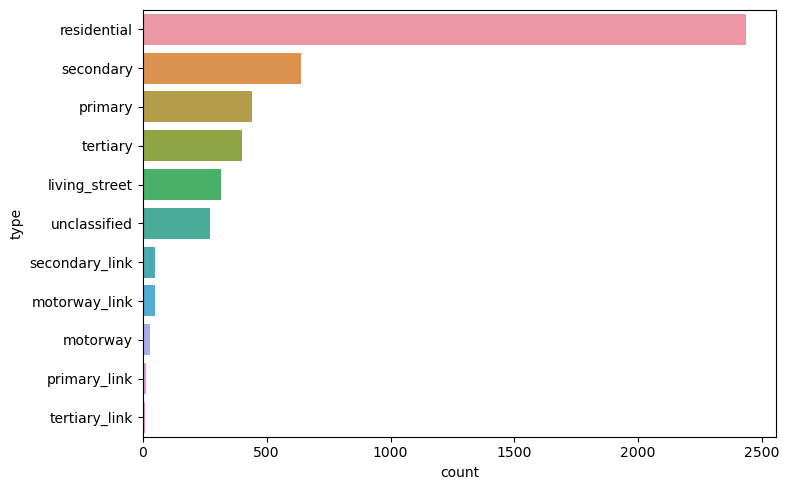

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(y="type", x="count", data=street_types, ax=ax)
plt.tight_layout()
plt.show();

### Putting the Street Network on a Folium Map

In [12]:
m = folium.Map([47.561086, 7.588686],
zoom_start=13,tiles="CartoDB dark_matter")

jsondata = streets.to_json()

style = {'color': '#FFDD66', 
         'weight':'1'}
folium.GeoJson(jsondata, style_function=lambda x: style).add_to(m)
m

### Routing

There are two train stations in Basel, lets find the route between them:

In [13]:
train_station_1 = ox.geocode('Badischer Bahnhof, Basel Switzerland')
train_station_1

(47.56701545, 7.608946057383559)

In [14]:
ox.geocode('Alexanderplatz, Berlin, Germany')

(52.52197645, 13.413637435864272)

In [15]:
train_station_2 = ox.geocode('Bahnhof SBB, Basel, Switzerland')
train_station_2

(47.54757255, 7.589416610940784)

#### Let's add them as POI to the map **above**:

In [ ]:
m = folium.Map([47.561086, 7.588686], zoom_start=13,tiles="CartoDB dark_matter")

#jsondata = streets.to_json()

style = {'color': '#FFDD66', 
         'weight':'1'}
folium.GeoJson(jsondata, style_function=lambda x: style).add_to(m)

folium.Marker(train_station_1, 
              popup="Badischer Bahnhof",
              icon=folium.Icon(color="green", prefix="fa", icon="train")).add_to(m)

folium.Marker(train_station_2, 
              popup="Bahnhof SBB",
              icon=folium.Icon(color="red", prefix="fa", icon="train")).add_to(m)
m

In [ ]:
origin_node = ox.distance.nearest_nodes(graph, train_station_1[1], train_station_1[0])  # G, X, Y    Longitude first!
destination_node = ox.distance.nearest_nodes(graph, train_station_2[1], train_station_2[0])

#### Find the route between the nodes

Using NetworkX module to calculate

In [ ]:
route = nx.shortest_path(graph, origin_node, destination_node)

In [ ]:
fig, ax = ox.plot_graph_route(graph, route)

In [ ]:
from shapely.geometry import LineString

line = []
for i in route:
    point = (graph.nodes[i]['x'],graph.nodes[i]['y'])
    line.append(point)
    print(point)
    
ls = LineString(line)

#### Create a GeoDataFrame from the LineString (optional)


In [ ]:
gdf_route = pd.DataFrame(data= [['route 1',ls]],columns=['route','geometry'])
gdf_route

In [ ]:
gdf_route = gpd.GeoDataFrame(gdf_route,geometry='geometry')
gdf_route

In [ ]:
gdf_route.plot();

Convert this route to GeoJSON

In [ ]:
jsonroute = gdf_route.to_json()

In [ ]:
m = folium.Map([47.561086, 7.588686], zoom_start=13,tiles="CartoDB dark_matter")

#jsondata = streets.to_json()

style = {'color': '#FFDD66', 
         'weight':'1'}

route_style = {'color': '#FF0000',
              'weight' : '4'}

folium.GeoJson(jsondata, style_function=lambda x: style).add_to(m)
folium.GeoJson(jsonroute, style_function=lambda x: route_style).add_to(m)

folium.Marker(train_station_1, 
              popup="Badischer Bahnhof",
              icon=folium.Icon(color="green", prefix="fa", icon="train")).add_to(m)

folium.Marker(train_station_2, 
              popup="Bahnhof SBB",
              icon=folium.Icon(color="red", prefix="fa", icon="train")).add_to(m)
m